# Authentication
When running this notebook in Colab and starting a new session, run this block to authenticate so the notebook can access Bigquery.

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# Start Here

In [2]:
#@title Firefox Stability Overview

#@markdown This notebook is a playground for prototyping visualizations of and analysis for Firefox stability data.

target_major_version = 88 #@param {type:"integer"}


# Init

In [ ]:
!pip install fx_crash_sig

In [294]:
project = 'mozdata'

from google.cloud import bigquery

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import sys
import os

from scipy import stats
from time import time
from collections import namedtuple
from fx_crash_sig.crash_processor import CrashProcessor

start_time = time()
crash_processor = CrashProcessor()
bq_client = bigquery.Client(project=project)
plt.rcParams['figure.figsize'] = (11,7)
pd.set_option('display.max_colwidth', None)

# Analysis

## Query Telemetry

In [5]:
# The number of weeks to query post-release. Reasonable range is 1 to 4.
# Crash Stats provides 1 week rolling window
weeks = 1

declares = f'''
DECLARE target_major_version DEFAULT {target_major_version};
DECLARE compare_major_version DEFAULT target_major_version - 1;
DECLARE weeks DEFAULT {weeks};
DECLARE target_min_date DEFAULT (
  SELECT
    date
  FROM `mozdata.telemetry.releases`
  WHERE mozfun.norm.truncate_version(version, 'major') = target_major_version
    AND category = 'major'
    AND product = 'firefox'
);

DECLARE compare_min_date DEFAULT (
  SELECT
    date
  FROM `mozdata.telemetry.releases`
  WHERE mozfun.norm.truncate_version(version, 'major') = compare_major_version
    AND category = 'major'
    AND product = 'firefox'
);

-- Query through no later than yesterday
DECLARE target_max_date DEFAULT IF(
    DATE_SUB(current_date, INTERVAL 1 DAY) > DATE_ADD(target_min_date, INTERVAL weeks WEEK),
    DATE_ADD(target_min_date, INTERVAL weeks WEEK),
    -- Pick the most recent day that is a multiple of 7 days from the `target_min_date`
    DATE_ADD(target_min_date, INTERVAL CAST(FLOOR(DATE_DIFF(DATE_SUB(current_date, INTERVAL 1 DAY), DATE '2021-06-01', DAY) / 7) AS INT64) WEEK)
);
DECLARE query_days DEFAULT DATE_DIFF(target_max_date, target_min_date, DAY);
DECLARE compare_max_date DEFAULT DATE_ADD(compare_min_date, INTERVAL query_days DAY);
'''

In [6]:
meta_df = bq_client.query(f'''
{declares}

SELECT
  target_major_version,
  target_min_date,
  target_max_date,
  compare_major_version,
  compare_min_date,
  compare_max_date,
  query_days,
''').to_dataframe()
meta_df

,target_major_version,target_min_date,target_max_date,compare_major_version,compare_min_date,compare_max_date,query_days
0,88,2021-04-19,2021-04-26,87,2021-03-23,2021-03-30,7


In [7]:
crash_telemetry_df = bq_client.query(f'''
{declares}

SELECT
  PARSE_DATE("%F", payload.crash_date) AS crash_date,
  client_id,
  normalized_channel AS channel,
  normalized_app_name,
  normalized_os,
  normalized_os_version,
  application.build_id,
  application.display_version AS version,
  payload,
FROM `moz-fx-data-shared-prod.telemetry.crash`
WHERE normalized_channel = 'release'
  AND normalized_app_name = 'Firefox'
  AND sample_id = 0
  AND ((
    DATE(submission_timestamp) BETWEEN target_min_date AND target_max_date
    AND mozfun.norm.truncate_version(application.display_version, 'major') = target_major_version
  ) OR (
    DATE(submission_timestamp) BETWEEN compare_min_date AND compare_max_date
    AND mozfun.norm.truncate_version(application.display_version, 'major') = compare_major_version
  ))
''').to_dataframe()
crash_telemetry_df.shape

(96863, 10)

In [9]:
socorro_df = bq_client.query(f'''
{declares}

WITH base AS (
  SELECT
    crash_date
    crash_id,
    release_channel AS channel,
    mozfun.norm.product_info(product, mozfun.norm.os(json_dump.system_info.os)).product AS normalized_app_name,
    mozfun.norm.os(json_dump.system_info.os) AS normalized_os,
    mozfun.norm.truncate_version(json_dump.system_info.os_ver, 'minor') AS normalized_os_version,
    build_id,
    version,
    process_type,
    version,
    minidump_sha256_hash,
    signature,
  FROM mozdata.telemetry.socorro_crash_v2 
  WHERE release_channel = 'release'
  AND ((
    crash_date BETWEEN target_min_date AND target_max_date
    AND mozfun.norm.truncate_version(version, 'major') = target_major_version
  ) OR (
    crash_date BETWEEN compare_min_date AND compare_max_date
    AND mozfun.norm.truncate_version(version, 'major') = compare_major_version
  ))
)

SELECT
  *
FROM base
WHERE normalized_app_name = 'Firefox'
''').to_dataframe()
socorro_df.shape

(240033, 11)

In [144]:
should_be_ints = [
  'payload.version',
  'payload.stack_traces.main_module',
  'payload.stack_traces.threads.module_index',
  'payload.stack_traces.threads.frames.module_index'
]


def noop(*args, **kws):
    return None


def deeptryset(d, key='', set_fn=noop):
  keys = key.split('.')
  next_key = keys[0]
  if isinstance(d, dict) and next_key in d:
    next_obj = d[next_key]
    if len(keys) > 1:
      remaining_keys = '.'.join(keys[1:])
      # Should be ok to use list specifically rather than interable since we're working with a dict loaded from JSON
      if isinstance(next_obj, list):
        for o in next_obj:
          deeptryset(o, remaining_keys, set_fn)
      else:
        deeptryset(next_obj, remaining_keys, set_fn)
    elif next_obj is not None:
      d[next_key] = set_fn(next_obj)


def get_signature(row):
  # Hacky workaround since fx-crash-sig doesn't seem to like some of the types Pandas produces with `to_dict`
  r_d = json.loads(row.to_json())
  for field in should_be_ints:
    deeptryset(r_d, field, int)
  deeptryset(r_d, 'payload.stack_traces.crash_info.crashing_thread', lambda x: -1 if x is None else int(x))
  old_stdout = sys.stdout
  sys.stdout = open(os.devnull, "w")
  try:
    result = crash_processor.get_signature(r_d).signature
  except Exception as ex:
    print(ex)
    result = '__get_signature_failed__'
  sys.stdout = old_stdout
  return result

crash_telemetry_df['signature'] = crash_telemetry_df[['normalized_os', 'payload']].apply(get_signature, axis=1)

In [304]:
tmp_grp = crash_telemetry_df[['signature', 'version', 'client_id']].groupby(['version', 'signature'])
crash_telemetry_summary_df = pd.concat([
  tmp_grp['client_id'].count() * 100, # Multiply by 100 to approximate count given 1% sample
  tmp_grp['client_id'].nunique() * 100,
  tmp_grp['client_id'].count()  / crash_telemetry_df.shape[0],
  tmp_grp['client_id'].nunique() / crash_telemetry_df['client_id'].nunique(),
  tmp_grp['client_id'].apply(lambda x: 'crash_ping')
], join='inner', axis=1)
crash_telemetry_summary_df.columns = ['crashes', 'clients', 'crashes_fraction', 'client_fraction', 'source']
crash_telemetry_summary_df.sort_values(by='crashes_fraction', ascending=False, inplace=True)
crash_telemetry_summary_df.reset_index(inplace=True)
crash_telemetry_summary_df.head(10)

,version,signature,crashes,clients,crashes_fraction,client_fraction,source
0,88.0,OOM | small,1301700,571900,0.134386,0.158645,crash_ping
1,87.0,OOM | small,1293400,562400,0.133529,0.156010,crash_ping
2,87.0,EMPTY: no crashing thread identified,412000,268000,0.042534,0.074343,crash_ping
3,88.0,EMPTY: no crashing thread identified,375200,258400,0.038735,0.071680,crash_ping
4,87.0,shutdownhang | mozilla::(anonymous namespace)::RunWatchdog,307500,182500,0.031746,0.050626,crash_ping
5,88.0,shutdownhang | mozilla::(anonymous namespace)::RunWatchdog,300100,183400,0.030982,0.050875,crash_ping
6,87.0,nsWidgetWindowsModuleCtor,261600,1100,0.027007,0.000305,crash_ping
7,87.0,OOM | large | js::AutoEnterOOMUnsafeRegion::crash | js::AutoEnterOOMUnsafeRegion::crash | js::gc::AllocateCellInGC,157500,107100,0.016260,0.029710,crash_ping
8,88.0,OOM | large | js::AutoEnterOOMUnsafeRegion::crash | js::AutoEnterOOMUnsafeRegion::crash | js::gc::AllocateCellInGC,119900,84400,0.012378,0.023413,crash_ping
9,87.0,EMPTY: no frame data available,102800,78200,0.010613,0.021693,crash_ping


In [303]:
tmp_grp = socorro_df[['signature', 'version', 'crash_id']].groupby(['version', 'signature'])
socorro_summary_df = pd.concat([
  tmp_grp['crash_id'].count(),
  tmp_grp['crash_id'].count()  / socorro_df.shape[0],
  tmp_grp['crash_id'].apply(lambda x: 'crash_report')
], join='inner', axis=1)
socorro_summary_df.columns = ['crashes', 'crashes_fraction', 'source']
socorro_summary_df.sort_values(by='crashes_fraction', ascending=False, inplace=True)
socorro_summary_df.reset_index(inplace=True)
socorro_summary_df.head(10)

,version,signature,crashes,crashes_fraction,source
0,87.0,OOM | small,31973,0.133203,crash_report
1,88.0,OOM | small,29312,0.122117,crash_report
2,87.0,OOM | large | js::AutoEnterOOMUnsafeRegion::crash | js::AutoEnterOOMUnsafeRegion::crash | js::gc::AllocateCellInGC,6826,0.028438,crash_report
3,88.0,OOM | large | js::AutoEnterOOMUnsafeRegion::crash | js::AutoEnterOOMUnsafeRegion::crash | js::gc::AllocateCellInGC,4377,0.018235,crash_report
4,87.0,js::GCMarker::processMarkStackTop,3416,0.014231,crash_report
5,88.0,static mozilla::dom::quota::QuotaManager::Shutdown::<T>::operator()::<T>::__invoke,2810,0.011707,crash_report
6,87.0,shutdownhang | mozilla::SpinEventLoopUntil<T> | mozilla::Preferences::SavePrefFileBlocking,2503,0.010428,crash_report
7,88.0,shutdownhang | mozilla::SpinEventLoopUntil<T> | mozilla::Preferences::SavePrefFileBlocking,2448,0.010199,crash_report
8,87.0,static mozilla::dom::quota::QuotaManager::Shutdown::<T>::operator()::<T>::__invoke,2363,0.009844,crash_report
9,88.0,js::GCMarker::processMarkStackTop,2064,0.008599,crash_report


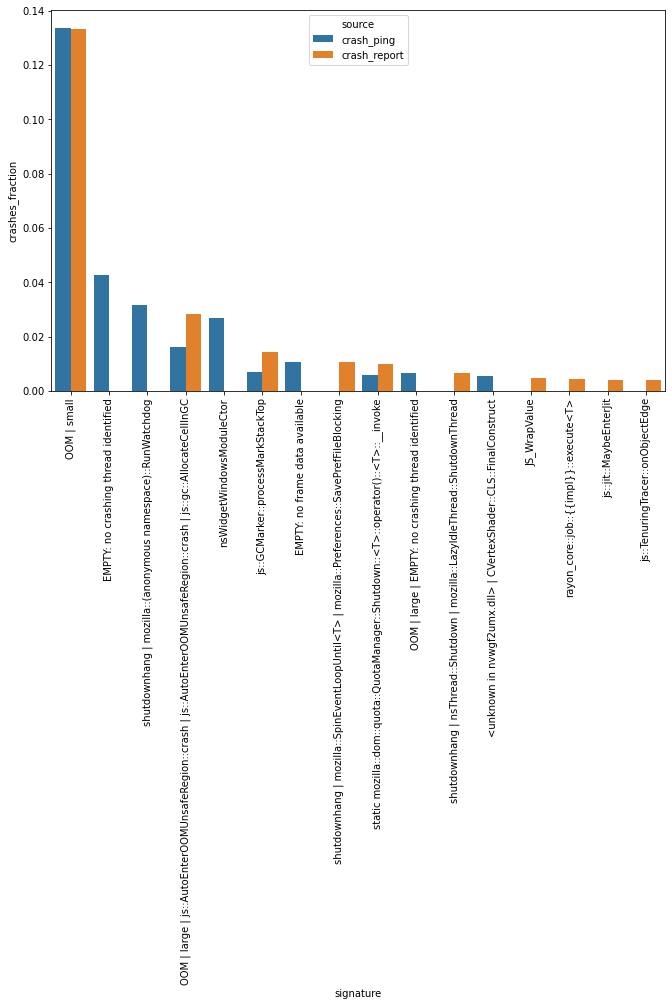

In [340]:
top_n = 10
columns = ['version', 'signature', 'crashes_fraction', 'source']
joined_crash_df = crash_telemetry_summary_df[columns] \
  .append(socorro_summary_df[columns])
joined_crash_df.sort_values(by='crashes_fraction', ascending=False, inplace=True)
joined_crash_df = joined_crash_df.groupby(['version', 'source']).head(top_n).reset_index()
ax = sns.barplot(data=joined_crash_df.query('version == "87.0"'), x='signature', y='crashes_fraction', hue='source')
plt.xticks(rotation=90)
plt.show()

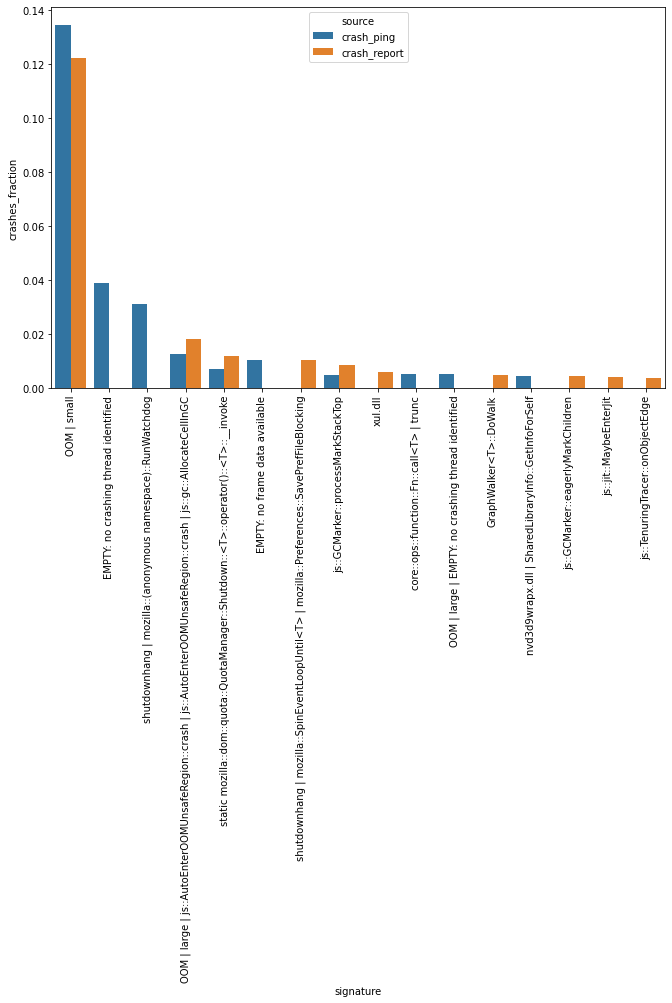

In [341]:
ax = sns.barplot(data=joined_crash_df.query('version == "88.0"'), x='signature', y='crashes_fraction', hue='source')
plt.xticks(rotation=90)
plt.show()

In [336]:
crash_telemetry_df[['signature','client_id']].groupby(['signature']).nunique().reset_index().sort_values(by='signature').to_csv('/c/Users/Eric Smyth/Desktop/signatures.csv')

In [338]:
crash_telemetry_df.query('signature == "__get_signature_failed__"').shape

(212, 11)

In [ ]:
print(f'Notebook execution took: {time() - start_time:.2f} seconds')

In [146]:
crash_telemetry_df.to_pickle('~/development/colab/2021_07_28_stability_working.pkl')

# Todo
* Plot crashes over time
* Determine if significant change in crashes between Fx87 and 88
* Review a set of top crashes for impact on retention


# Notes
Not practical to run this at scale. 1-week 1% sample of the Release channel crash pings for 2 versions is ~100k records and the time to run fx-crash-sig to generate signatures is near 4.7 hours (`175ms/record).

What does it mean if 'payload.stack_traces.crash_info.crashing_thread' is None? 

Are the crashes captured by the newly introduced WER reporting reported via telemetry or just socorro? if not telemetry, are there other known cases where a crash may be reported in socorro but not telemetry?

Aggregation right now is per row. There isn't de-duplication of crash_id in either the socorro or telemetry dataframes. There seems to be a significant number of rows in socorro per unique crash_id. I need to better understand what a crash_id and a row from each data source represents.

The signature generation step failed on 212 out of 96863 records. Willkg also mentioned there are cases where the signature generated for a ping is more generic than what the equivalent crash would have in socorro (`for example "EMPTY: no crashing thread identified" shows up in crash report data as "EMPTY: no crashing thread identified: <reason>" and there are a bunch of reasons.`)

What is the structure of the signature, specifically the meaning of the `|` delimiter (example signature `<unknown in atidxx64.dll> | <unknown in atiumd6a.dll> | <unknown in atidxx64.dll> | <unknown in atiuxp64.dll> | CDecodeContext::EndFrame`)? Would it be meaningful to also look at crashes at some substring (e.g., only the chunk before the first delimiter)?